## Load predictions + (optional) anomaly labels

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score

PRED_PATH = "../data/forecast_predictions.parquet"
pred = pd.read_parquet(PRED_PATH).sort_values("date").reset_index(drop=True)

# bring labels (if present) by merging on date from the original dataset
df_raw = pd.read_csv("../data/synthetic_kpi.csv", parse_dates=["date"]).sort_values("date")
pred = pred.merge(df_raw[["date"] + (["is_anomaly"] if "is_anomaly" in df_raw.columns else [])], on="date", how="left")

pred.head()

,date,y_true,y_pred_naive,y_pred_rf,y_pred_gbr,is_anomaly
0,2022-08-02,136.917880,128.837856,128.657569,130.447388,0
1,2022-08-03,128.704878,136.917880,129.774750,131.850201,0
2,2022-08-04,130.759613,128.704878,126.452089,126.814752,0
3,2022-08-05,120.303069,130.759613,115.783941,116.297529,0
4,2022-08-06,106.001910,120.303069,109.138298,108.144682,0


## Residuals

In [2]:
pred["resid_rf"] = pred["y_true"] - pred["y_pred_rf"]
pred["abs_resid_rf"] = pred["resid_rf"].abs()

pred["resid_gbr"] = pred["y_true"] - pred["y_pred_gbr"]
pred["abs_resid_gbr"] = pred["resid_gbr"].abs()

pred[["date","y_true","y_pred_rf","resid_rf","abs_resid_rf"]].head()

,date,y_true,y_pred_rf,resid_rf,abs_resid_rf
0,2022-08-02,136.917880,128.657569,8.260311,8.260311
1,2022-08-03,128.704878,129.774750,-1.069872,1.069872
2,2022-08-04,130.759613,126.452089,4.307523,4.307523
3,2022-08-05,120.303069,115.783941,4.519128,4.519128
4,2022-08-06,106.001910,109.138298,-3.136388,3.136388


## Statistical anomaly (rolling z-score on residuals)

In [3]:
w = 28
eps = 1e-6
rolling_mean = pred["resid_rf"].rolling(w).mean()
rolling_std  = pred["resid_rf"].rolling(w).std().replace(0, eps)

pred["z_resid_rf"] = (pred["resid_rf"] - rolling_mean) / rolling_std
pred["anom_z"] = (pred["z_resid_rf"].abs() > 3.0).astype(int)

pred[["z_resid_rf","anom_z"]].dropna().head()


,z_resid_rf,anom_z
27,-0.377881,0
28,0.125733,0
29,0.826712,0
30,-0.575667,0
31,-0.506027,0


## Unsupervised anomaly (IsolationForest on residual features)

In [4]:
feat = pred[["resid_rf","abs_resid_rf","resid_gbr","abs_resid_gbr"]].fillna(0.0).values

iso = IsolationForest(
    n_estimators=300,
    contamination=0.02,  # tune this
    random_state=42
)
iso.fit(feat)

# IsolationForest: -1 = anomaly
pred["anom_iso"] = (iso.predict(feat) == -1).astype(int)
pred[["anom_z","anom_iso"]].head()

,anom_z,anom_iso
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


## Visualize anomalies

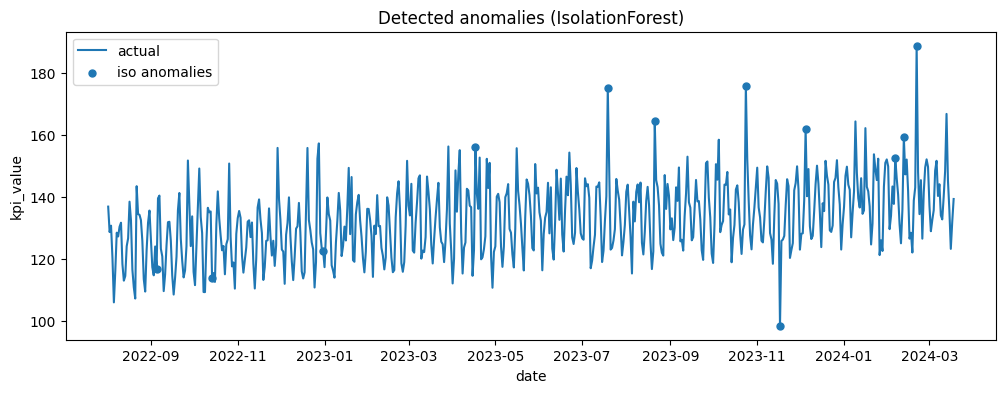

In [5]:
plt.figure(figsize=(12,4))
plt.plot(pred["date"], pred["y_true"], label="actual")

anom_points = pred[pred["anom_iso"] == 1]
plt.scatter(anom_points["date"], anom_points["y_true"], s=25, label="iso anomalies")

plt.title("Detected anomalies (IsolationForest)")
plt.xlabel("date")
plt.ylabel("kpi_value")
plt.legend()
plt.show()

## Evaluate (only if labels exist)

In [6]:
if "is_anomaly" in pred.columns and pred["is_anomaly"].notna().any():
    y_true = pred["is_anomaly"].fillna(0).astype(int).values

    for col in ["anom_z", "anom_iso"]:
        y_pred = pred[col].values
        p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
        print(f"{col}: Precision={p:.3f} Recall={r:.3f} F1={f1:.3f}")

    # optional: score-based AUC using abs residual as a score
    try:
        auc = roc_auc_score(y_true, pred["abs_resid_rf"].values)
        print("AUC(abs_resid_rf) =", round(auc, 3))
    except Exception as e:
        print("AUC not available:", e)
else:
    print("No labels available; focus on qualitative review + stability + false-positive control.")

anom_z: Precision=0.750 Recall=1.000 F1=0.857
anom_iso: Precision=0.500 Recall=1.000 F1=0.667
AUC(abs_resid_rf) = 0.999


## Save anomaly outputs

In [7]:
OUT_PATH = "../data/anomaly_outputs.parquet"
pred.to_parquet(OUT_PATH, index=False)
print("Saved:", OUT_PATH)

Saved: ../data/anomaly_outputs.parquet
